Treat image ROI takes electron diffraction patterns and calibrate the image, rotate it, draw the BZ around the Bragg peak and average equivalent BZ together

In [31]:
import sys
sys.path.append('../../')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Polygon
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imutils
import glob
import cv2  # importing cv
import find_peak
import scipy.special as special
from matplotlib import ticker
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
import nfft
import scipy
import scipy.fft
import functions_analysis as fa
from skimage import img_as_float
from skimage import filters
%matplotlib inline 

path = r'C:\Users\rclaude\Documents\projet\graphite\drawing\UED_fig'
path_main=path+r'\data'
scans = [ '1.55 eV',  '3.1 eV' ]
scan_number = [ 'r464',  'r471' ]

data = {}

for k, scan_name in enumerate(scans):
    data[scan_name] = {}
    data[scan_name] = {}
    df= pd.read_pickle(path_main + r'\PROC_'+ scan_number[k], 
                       compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

    data[scan_name]['imgOFF'] = np.stack(df['imgOFF'])
    data[scan_name]['imgON'] = np.stack(df['imgON'])
    data[scan_name]['delay'] = np.stack(df['delay'])
    data[scan_name]['t0_index'] = df.attrs['t0_index']
    # print(df.attrs['peak_dist'])
    data[scan_name]['Zorder'] = df.attrs['Zorder_pos']
    data[scan_name]['cal'] = df.attrs['calibration']

    data[scan_name]['kx'] = data[scan_name]['cal'] *(np.arange(np.size(data[scan_name]['imgON'][0],1)) -
                                                      data[scan_name]['Zorder'] [1])
    data[scan_name]['ky'] = data[scan_name]['cal'] *(np.arange(np.size(data[scan_name]['imgON'][0],0)) - 
                                                     data[scan_name]['Zorder'] [0])


In [32]:
L = df.attrs['peak_dist']
Zorder = df.attrs['Zorder_pos']
cal = df.attrs['calibration']
t0 = df.attrs['t0_index']

# cc = L2/2 * np.exp(1j * np.pi * ( 1./2 * np.arange(5)))## for squared BZ
cc =  L * np.sqrt(3)/3 *np.exp(1j * np.pi  * ( 1./3 * np.arange(7))) ## for hexagonal BZ


#### construction position of the Bragg peak, ordered by family
BP_BZ = []
for i in range(6):
    BP_BZ.append([L*np.cos(np.pi*i/3), L*np.sin(np.pi*i/3)])
BP_pos = [Zorder + np.array(BP_BZ)]
BP_BZ = []
for i in range(6):
    BP_BZ.append([2*L*np.cos(np.pi*i/3), 2*L*np.sin(np.pi*i/3)])
BP_pos.append(Zorder + np.array(BP_BZ))
BP_BZ = []
for i in range(6):
    BP_BZ.append([np.sqrt(3)*L*np.cos(np.pi*i/3+np.pi/6), np.sqrt(3)*L*np.sin(np.pi*i/3+np.pi/6)])
BP_pos.append(Zorder + np.array(BP_BZ))
BP_name = ['{100}', '{200}', '{110}']
BP_BZ = []
print(BP_pos)


#### construction position of the K-pont, ordered by family

edge = L*np.tan(np.pi/6)
BP_DS = []
for i in range(6):
    BP_DS.append([2*edge*np.cos(np.pi*i/3+np.pi/6), 2*edge*np.sin(np.pi*i/3+np.pi/6)])
DS_pos = [Zorder + np.array(BP_DS)]
BP_DS = []
for i in range(6):
    BP_DS.append([4*edge*np.cos(np.pi*i/3+np.pi/6), 4*edge*np.sin(np.pi*i/3+np.pi/6)])
DS_pos.append(Zorder + np.array(BP_DS))
BP_DS = []
for i in range(6):  
    BP_DS.append(fa.rotate_vector(np.array([3*L/2, edge/2]), i*np.pi/3))
    BP_DS.append(fa.rotate_vector(np.array([3*L/2,-edge/2]), i*np.pi/3))
DS_pos.append(Zorder + np.array(BP_DS))
BP_DS = []
for i in range(6):
    BP_DS.append(fa.rotate_vector(np.array([2*L, edge]), i*np.pi/3))
    BP_DS.append(fa.rotate_vector(np.array([2*L,-edge]), i*np.pi/3))
DS_pos.append(Zorder + np.array(BP_DS))
BP_DS = []
    # BP_DS.append(fa.rotate_vector(np.array([5*L/2, edge/2]), i*np.pi/3))
    # BP_DS.append(fa.rotate_vector(np.array([5*L/2,-edge/2]), i*np.pi/3))

DS_name = [r'$\Gamma \to K$ first order', r'$\Gamma \to K$ second order', r'$\Gamma \to M$ first order', r'$\Gamma \to M$ second order']

[array([[335.11513023, 248.94698604],
       [287.74996591, 330.98585715],
       [193.01963728, 330.98585715],
       [145.65447296, 248.94698604],
       [193.01963728, 166.90811493],
       [287.74996591, 166.90811493]]), array([[429.84545887, 248.94698604],
       [335.11513023, 413.02472826],
       [145.65447296, 413.02472826],
       [ 50.92414432, 248.94698604],
       [145.65447296,  84.86924382],
       [335.11513023,  84.86924382]]), array([[382.48029455, 330.98585715],
       [240.3848016 , 413.02472826],
       [ 98.28930864, 330.98585715],
       [ 98.28930864, 166.90811493],
       [240.3848016 ,  84.86924382],
       [382.48029455, 166.90811493]])]


C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\1636563162.py:11: RuntimeWarning: invalid value encountered in divide
  diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0], axis=0) - \
C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\1636563162.py:12: RuntimeWarning: invalid value encountered in divide
  (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0], axis=0)


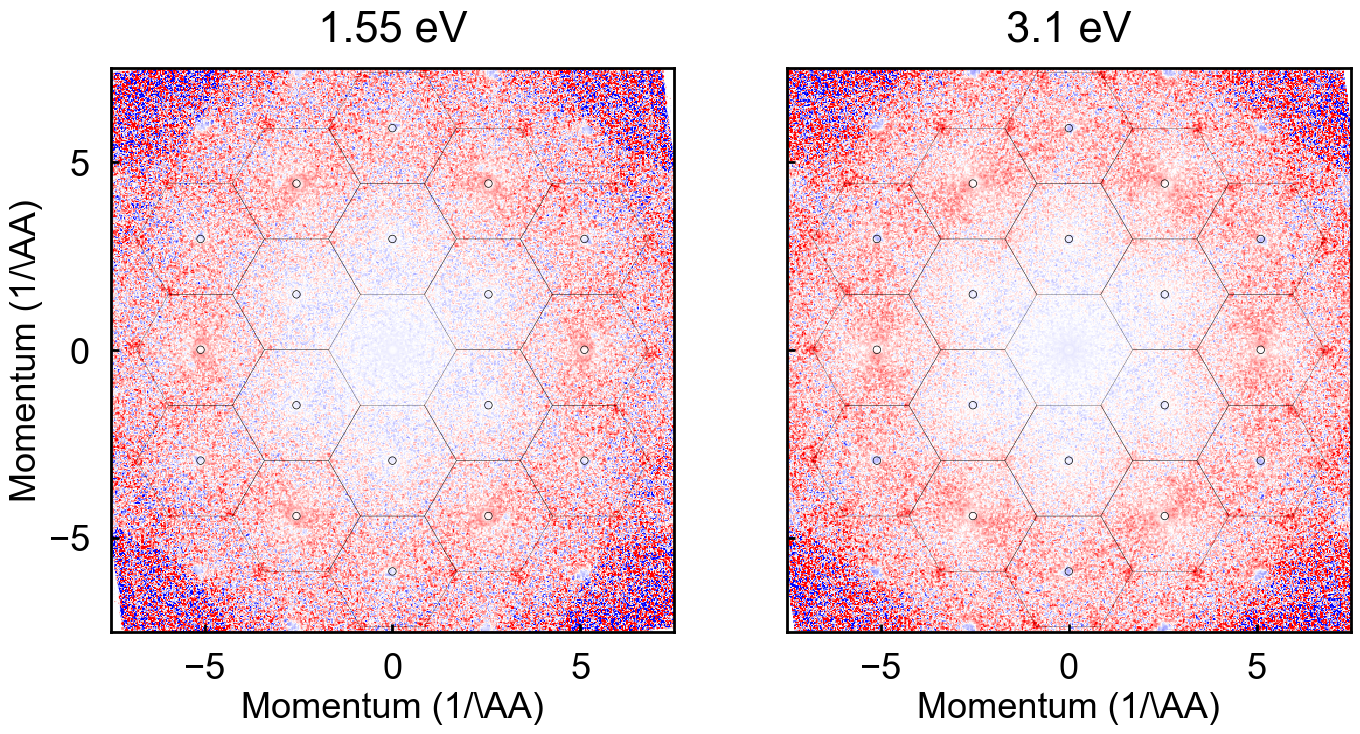

In [33]:
plt.figure(figsize = (16, 8))

lim=7.5
for k, scan_name in enumerate(scans):

    beforet0 =  data[scan_name]['delay']<-0.5
    # aftert0 = ( data[scan_name]['delay']>0.1 ) & ( data[scan_name]['delay']<2)
    # aftert0 = ( data[scan_name]['delay']>2 ) & ( data[scan_name]['delay']<5)
    aftert0 = ( data[scan_name]['delay']>0.2 ) & ( data[scan_name]['delay']<10)

    diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0], axis=0) - \
        (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0], axis=0)
    ax = plt.subplot(1,2 ,k+1)
    ax.pcolorfast(data[scan_name]['kx'], data[scan_name]['ky'], diff, vmin=-0.01, vmax = 0.01, cmap = 'bwr')
    plt.gca().set_aspect('equal')

    plt.title(scan_name, pad = 20)

    plt.xlim([-lim, lim]), plt.ylim([-lim, lim])
    plt.xticks([-5, 0, 5]), plt.yticks([-5, 0, 5])

    plt.xlabel(r'Momentum (1/\AA)')
    if k ==0:
        plt.ylabel(r'Momentum (1/\AA)')
    else:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', direction='in', pad = 15)
    for i in range(len(BP_pos)):
        for j in range(len(BP_pos[i])):
            ax.add_patch(Circle((cal*(Zorder[1]-BP_pos[i][j][1]), cal*(Zorder[0]-BP_pos[i][j][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))
            ax.add_patch(Polygon(cal*np.c_[(cc.real+Zorder[1]-BP_pos[i][j][1]), (cc.imag+Zorder[0]-BP_pos[i][j][0])],
                lw=0.2, edgecolor='k',
                clip_on=False, facecolor='none'))
            
    

In [34]:
plt.rcParams.update({'font.size': 20})
plt.rc('axes', linewidth=2)
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 1
plt.rc('axes', linewidth=2)
# plt.rc('font', weight='semibold')
# plt.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath'
plt.rc('font', family='arial',size=26)#, weight='bold')
plt.rc('text', usetex=False)

In [35]:
for scan_name in scans:
    data[scan_name]['imgON_not_filtered'] = data[scan_name]['imgON']
    data[scan_name]['imgOFF_not_filtered'] = data[scan_name]['imgOFF']

In [36]:
s = 1
for scan_name in scans:
    data[scan_name]['imgON'] = filters.gaussian(img_as_float(data[scan_name]['imgON']), sigma=s)
    data[scan_name]['imgOFF'] = filters.gaussian(img_as_float(data[scan_name]['imgOFF']), sigma=s)

[335.11513023 248.94698604]
[248 145]


C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\1123457866.py:41: RuntimeWarning: invalid value encountered in divide
  diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0], axis=0) - \
C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\1123457866.py:42: RuntimeWarning: invalid value encountered in divide
  (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0], axis=0)
C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\1123457866.py:41: RuntimeWarning: invalid value encountered in divide
  diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0], axis=0) - \
C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\1123457866.py:42: RuntimeWarning: invalid value encountered in divide
  (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0], axis=0)
C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\1123457866.py:4

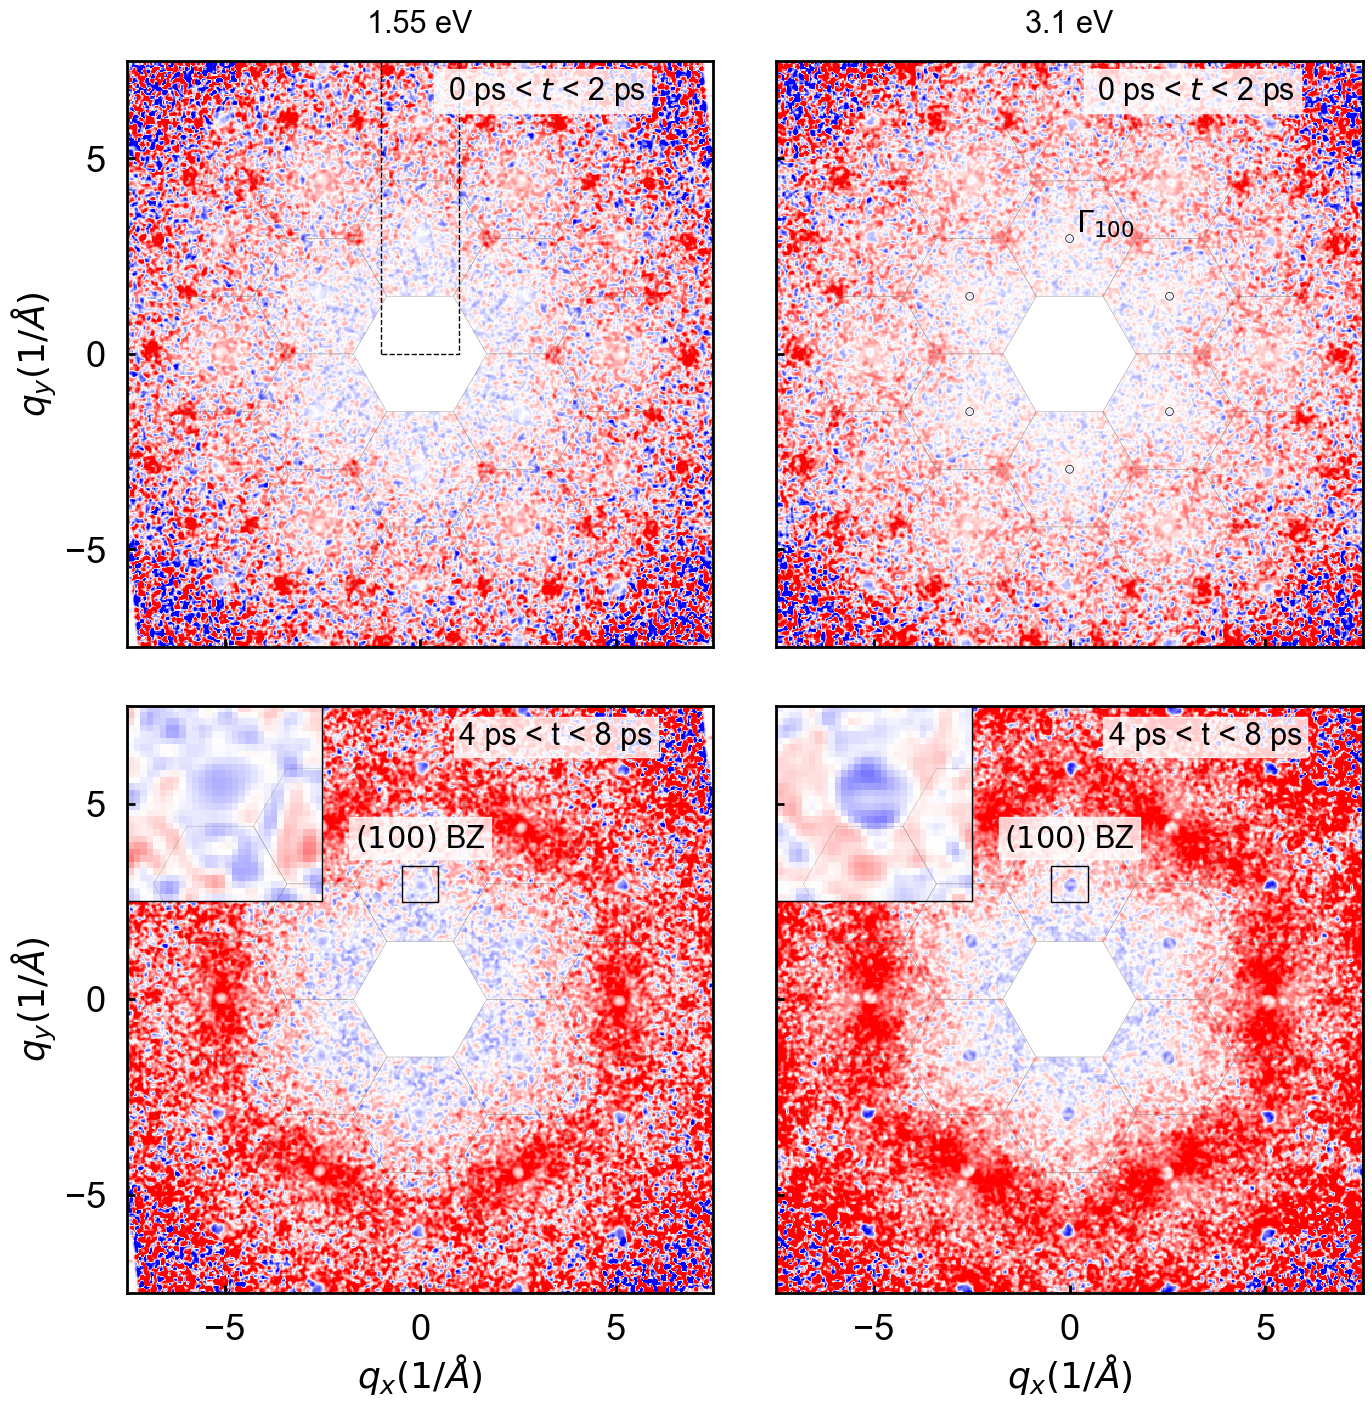

In [37]:
####################### GOOD VERSION 1 ##################################
a= 2.46
# a = 1.42
b =(4*np.pi/(np.sqrt(3)*a)) 
w = 1
## parameter for the binning
C = np.array([0,0])
print(BP_pos[0][0])
t1, t2, t3, t4 = 0, 2, 4, 8

alpha = 0.3
# rectangle_hor = np.array([[-0, (C[0]-w)],[6.5,(C[0]-w)],[6.5,(C[0]+w)], [0, (C[0]+w)]])
rectangle_ver = np.array([[(C[1]-w),-0],[(C[1]-w), 7.5],[(C[1]+w),7.5], [(C[1]+w),0]])
x=3
BP_zoom = np.array([ Zorder[0]-BP_pos[0][x][0],Zorder[1]-BP_pos[0][x][1]])
BP_zoom_int = np.array([BP_pos[0][x][1],BP_pos[0][x][0]], dtype=(np.int64))
print(BP_zoom_int)
a = 15
square_zoom = cal*np.array([[(BP_zoom[1]-a),BP_zoom[0]-a], [(BP_zoom[1]-a),BP_zoom[0]+a], [(BP_zoom[1]+a),BP_zoom[0]+a], [(BP_zoom[1]+a),BP_zoom[0]-a]])

square_zoom_inset = -np.array([[2.5, -7.5], [2.5, -2.5], [7.5, -2.5], [7.5, -7.5]])


plt.figure(figsize = (16, 16))

order = [0,2, 1, 3]
count = 0
sens=0.004
gs = gridspec.GridSpec(2,2, width_ratios=(1,1), wspace = 0.1, hspace = 0.1)

for k, scan_name in enumerate(scans):
    beforet0 =  data[scan_name]['delay']<-0.5
    for kk in [0,1]:
        # aftert0 = ( data[scan_name]['delay']>0.1 ) & ( data[scan_name]['delay']<2)
        if kk==0:
            aftert0 = ( data[scan_name]['delay']>t1 ) & ( data[scan_name]['delay']<t2)

        else:
            aftert0 = ( data[scan_name]['delay']>t3 ) & ( data[scan_name]['delay']<t4)

        diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0], axis=0) - \
            (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0], axis=0)
        # diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0)-np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgON'][beforet0], axis=0)
        # diff = ((np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgON'][aftert0]) - (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgON'][beforet0]))
        # diff = ((np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgON'][aftert0]) - (np.mean(data[scan_name]['imgOFF'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0])) \
        # - ((np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgON'][beforet0]) - (np.mean(data[scan_name]['imgOFF'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0]))
        ax = plt.subplot(gs[order[count]])
        ax.pcolorfast(data[scan_name]['kx'], data[scan_name]['ky'], diff, vmin=-sens, vmax = sens, cmap = 'bwr')
        plt.gca().set_aspect('equal')

        plt.xlim([-lim, lim ]), plt.ylim([-lim, lim])

        plt.xticks([-5, 0, 5]), plt.yticks([-5, 0, 5])
        # b=3
        # plt.xticks([-2*b, -b, 0, b, 2*b]), plt.yticks([-2*b, -b, 0, b, 2*b])

        if order[count] == 0 or order[count] ==2:
            plt.ylabel(r'$q_y (1/\AA)$')
        else:
            ax.set_yticklabels([])
        if order[count] >1:
            plt.xlabel(r'$q_x (1/\AA)$')
        else:
            ax.set_xticklabels([])
            plt.title(scan_name, fontsize=22, pad = 20)
        
        ax.tick_params(axis='both', direction='in', pad = 15)
        count+=1
        for i in range(len(BP_pos)):
            for j in range(len(BP_pos[i])):
                # ax.add_patch(Circle((cal*(Zorder[1]-BP_pos[i][j][1]), cal*(Zorder[0]-BP_pos[i][j][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))
                ax.add_patch(Polygon(cal*np.c_[(cc.real+Zorder[1]-BP_pos[i][j][1]), (cc.imag+Zorder[0]-BP_pos[i][j][0])],
                    lw=0.2, edgecolor='gray',
                    clip_on=False, facecolor='none'))
        ax.add_patch(Polygon(cal*np.c_[(cc.real), (cc.imag)],
                    lw=0.2, edgecolor='gray',
                    clip_on=True, facecolor='white'))
        if k==0 and kk == 0:
            ax.add_patch(Polygon(rectangle_ver, lw=1, linestyle='--', edgecolor='k', fill=False, facecolor='y', alpha=1))

        if kk==0 and k==1:
            for i in range(len(BP_pos[0])):
                ax.add_patch(Circle((cal*(Zorder[1]-BP_pos[0][i][1]), cal*(Zorder[0]-BP_pos[0][i][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))
                # t = plt.text(cal_b*(Zorder[1]-BP_pos[0][i][1]+5), cal_b*(Zorder[0]-BP_pos[0][i][0]+5), r'$\Gamma_{100}$', c='k', fontsize = 22, ha='left')#, fontweight = 'semibold')

            t = plt.text(cal*(Zorder[1]-BP_pos[0][x][1]+5), cal*(Zorder[0]-BP_pos[0][x][0]+5), r'$\Gamma_{100}$', c='k', fontsize = 22, ha='left', fontweight = 'bold')
        # ax.add_patch(Circle((cal*(Zorder[1]-BP_pos[0][3][1]), cal*(Zorder[0]-BP_pos[0][3][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))

        if kk==0:
            aftert0 = ( data[scan_name]['delay']>0.1 ) & ( data[scan_name]['delay']<2)
            text_time = r'0.1 ps $<$\textit{t}$<$ 2 ps'
            text_time = r'%2.f ps < $t$ < %d ps'%(t1,t2)
            t = plt.text(0.5, 6.5, text_time, c='k', fontsize = 22)#, fontweight = 'semibold')
            t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

        else:
            aftert0 = ( data[scan_name]['delay']>2 ) & ( data[scan_name]['delay']<8)
            text_time = r'2 ps $<\textit{t}<$ 8 ps'
            text_time = r'%d ps < t < %d ps'%(t3,t4)
            t = plt.text(1, 6.5, text_time, c='k', fontsize = 22)#, fontweight = 'semibold')
            t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

        if kk == 1:
            ax.add_patch(Polygon(square_zoom, lw=1, linestyle='-', edgecolor='k', fill=False, facecolor='y', alpha=1))
            # ax.imshow(diff[(BP_zoom_int[1]-a):(BP_zoom_int[1]+a), BP_zoom_int[0]-a:BP_zoom_int[0]+a], vmin=-sens, vmax = sens, cmap = 'bwr')#, aspect='equal')
            ax.add_patch(Polygon(square_zoom_inset, lw=1, linestyle='-', edgecolor='k', fill=False, facecolor='y', alpha=1))
            ax.imshow(diff[(BP_zoom_int[1]-a):(BP_zoom_int[1]+a), BP_zoom_int[0]-a:BP_zoom_int[0]+a], vmin=-sens, vmax = sens, cmap = 'bwr', extent=(-2.5, -7.5, 7.5, 2.5))#, origin='lower')#, aspect='equal')
            t = plt.text(cal*(Zorder[1]-BP_pos[0][x][1]), cal*(Zorder[0]-BP_pos[0][x][0]+30), r'$(100)$ BZ', c='k', fontsize = 22, ha='center')
            t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
            # ax.add_patch(Polygon(square_zoom_inset, lw=1, linestyle='-', edgecolor='k', fill=True, facecolor='y', alpha=1))
            
# plt.savefig(path+r'\diff_UED.png', bbox_inches='tight', dpi =600)
plt.savefig(path+r'\diff_UED.pdf', format='pdf', bbox_inches='tight')


In [ ]:

a= 2.46
# a = 1.42
b =(4*np.pi/(np.sqrt(3)*a)) 
print(b)
cal_b = cal/b
print(cal_b)

[335.11513023 248.94698604]
[248 145]


C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\2035001398.py:47: RuntimeWarning: invalid value encountered in divide
  diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0], axis=0) - \
C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\2035001398.py:48: RuntimeWarning: invalid value encountered in divide
  (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0], axis=0)
C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\2035001398.py:49: RuntimeWarning: invalid value encountered in divide
  diff_2=(np.mean(data[scan_name]['imgON_not_filtered'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF_not_filtered'][aftert0], axis=0) - \
C:\Users\rclaude\AppData\Local\Temp\ipykernel_8932\2035001398.py:50: RuntimeWarning: invalid value encountered in divide
  (np.mean(data[scan_name]['imgON_not_filtered'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF_not_filtered'][beforet0], axis=0)
C:\Users\rcl

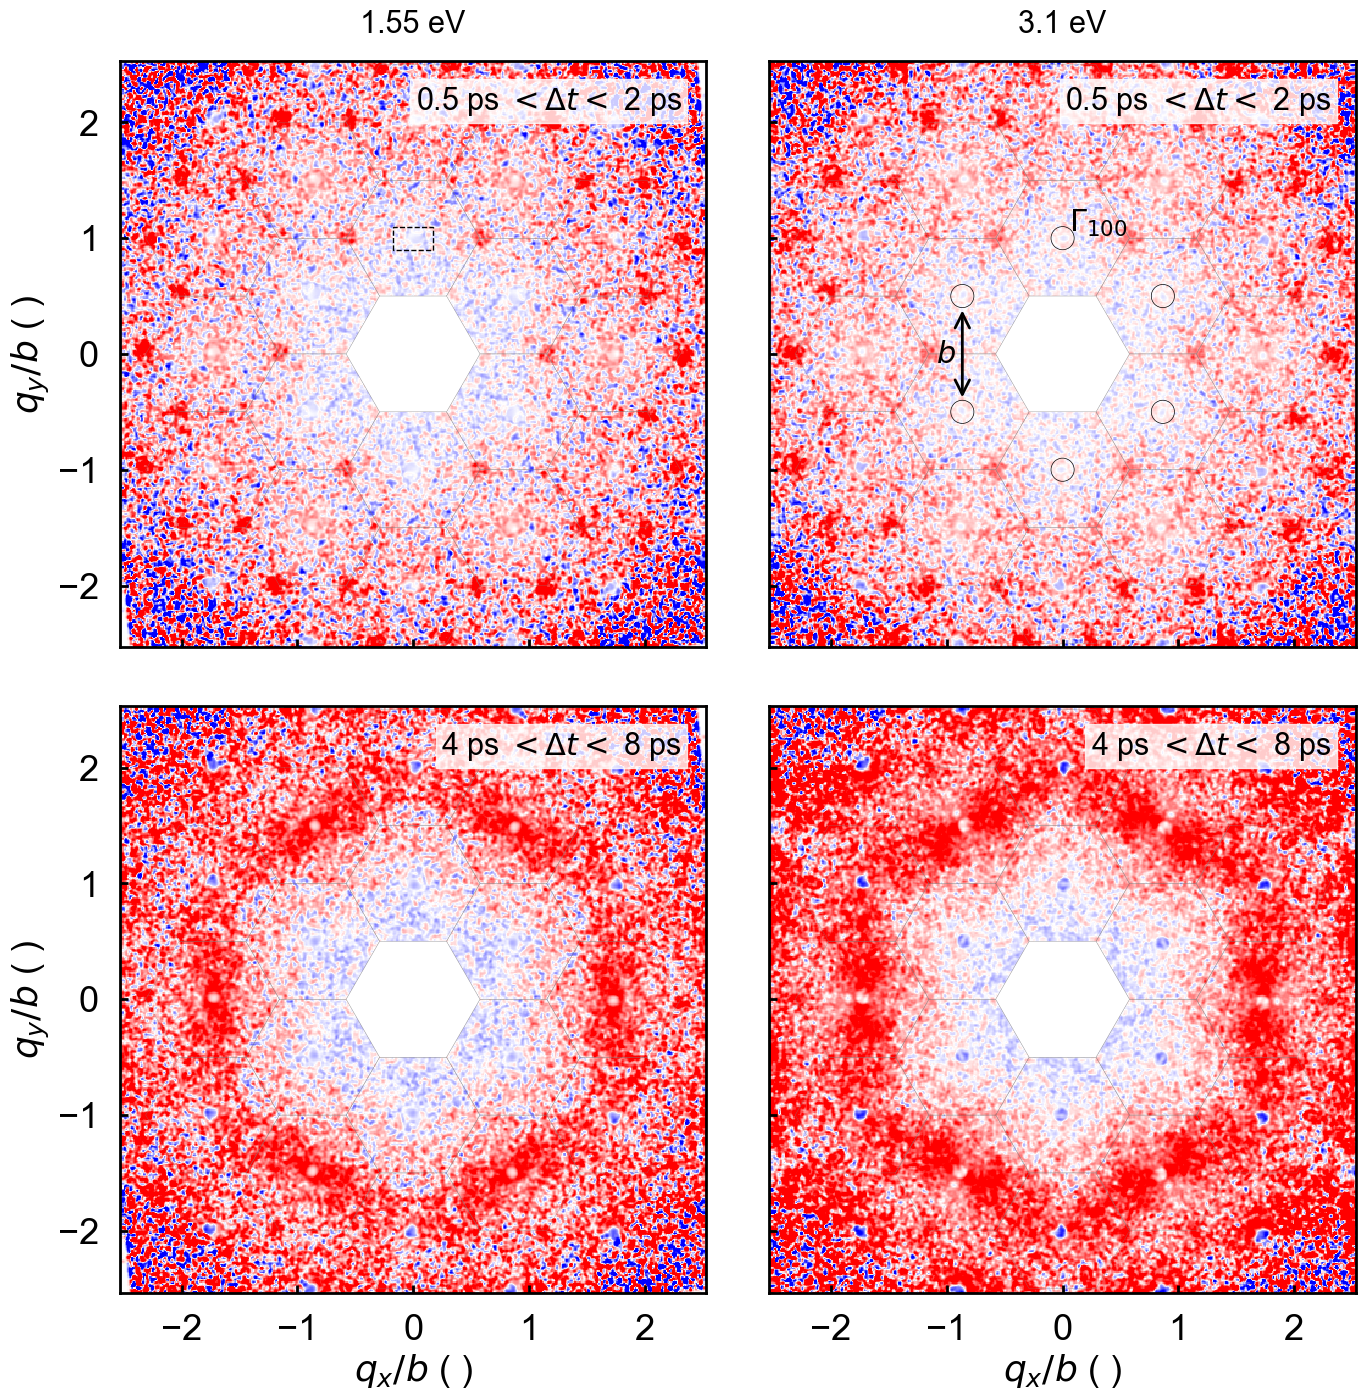

In [ ]:
####################### GOOD VERSION 2 ##################################
kx_cal_b = data[scan_name]['kx']/b
ky_cal_b = data[scan_name]['ky']/b


w = .5/b
## parameter for the binning
C = np.array([0,0])
print(BP_pos[0][0])
t1, t2, t3, t4 = 0.5, 2, 4, 8
lim = 240*cal_b
tick = 1
alpha = 0.3
# rectangle_hor = np.array([[-0, (C[0]-w)],[6.5,(C[0]-w)],[6.5,(C[0]+w)], [0, (C[0]+w)]])
rectangle_ver = np.array([[(C[1]-w),0.9],[(C[1]-w), 1.1],[(C[1]+w),1.1], [(C[1]+w),0.9]])
x=3
y=1
BP_zoom = np.array([ Zorder[0]-BP_pos[0][x][0],Zorder[1]-BP_pos[0][x][1]])
BP_zoom_int = np.array([BP_pos[0][x][1],BP_pos[0][x][0]], dtype=(np.int64))
print(BP_zoom_int)
a = 7
abis=10
square_zoom = cal_b*np.array([[(BP_zoom[1]-a),BP_zoom[0]-a], [(BP_zoom[1]-a),BP_zoom[0]+a], [(BP_zoom[1]+a),BP_zoom[0]+a], [(BP_zoom[1]+a),BP_zoom[0]-a]])
e1 = 2*lim/6
e2 = lim
square_zoom_inset = -np.array([[e1, -e2], [e1, -e1], [e2, -e1], [e2, -e2]])

BP_100_name = [r'$\Gamma_{100}$', r'$\Gamma_{1-10}$',r'$\Gamma_{0}$',r'$\Gamma_{100}$',r'$\Gamma_{100}$',r'$\Gamma_{100}$']

plt.figure(figsize = (16, 16))

order = [0,2, 1, 3]
count = 0
sens=0.004
gs = gridspec.GridSpec(2,2, width_ratios=(1,1), wspace = 0.1, hspace = 0.1)

for k, scan_name in enumerate(scans):
    beforet0 =  data[scan_name]['delay']<-0.5
    for kk in [0,1]:
        # aftert0 = ( data[scan_name]['delay']>0.1 ) & ( data[scan_name]['delay']<2)
        if kk==0:
            aftert0 = ( data[scan_name]['delay']>t1 ) & ( data[scan_name]['delay']<t2)

        else:
            aftert0 = ( data[scan_name]['delay']>t3 ) & ( data[scan_name]['delay']<t4)

        diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0], axis=0) - \
            (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0], axis=0)
        diff_2=(np.mean(data[scan_name]['imgON_not_filtered'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF_not_filtered'][aftert0], axis=0) - \
            (np.mean(data[scan_name]['imgON_not_filtered'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF_not_filtered'][beforet0], axis=0)
        # diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0)-np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgON'][beforet0], axis=0)
        # diff = ((np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgON'][aftert0]) - (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgON'][beforet0]))
        # diff = ((np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgON'][aftert0]) - (np.mean(data[scan_name]['imgOFF'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0])) \
        # - ((np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgON'][beforet0]) - (np.mean(data[scan_name]['imgOFF'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0]))
        ax = plt.subplot(gs[order[count]])
        ax.pcolorfast(kx_cal_b, ky_cal_b, diff, vmin=-sens, vmax = sens, cmap = 'bwr')
        plt.gca().set_aspect('equal')
        plt.xlim([-lim, lim]), plt.ylim([-lim, lim])
        plt.xticks([-2*tick, -tick, 0, tick, 2*tick]), plt.yticks([-2*tick, -tick, 0, tick, 2*tick])

        if order[count] == 0 or order[count] ==2:
            plt.ylabel(r'$q_y/b$')
        else:
            ax.set_yticklabels([])
        if order[count] >1:
            plt.xlabel(r'$q_x/b$')
        else:
            ax.set_xticklabels([])
            plt.title(scan_name, fontsize=22, pad = 20)
        
        ax.tick_params(axis='both', direction='in', pad = 15)
        count+=1
        for i in range(len(BP_pos)):
            for j in range(len(BP_pos[i])):
                # ax.add_patch(Circle((cal_b*(Zorder[1]-BP_pos[i][j][1]), cal_b*(Zorder[0]-BP_pos[i][j][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))
                ax.add_patch(Polygon(cal_b*np.c_[(cc.real+Zorder[1]-BP_pos[i][j][1]), (cc.imag+Zorder[0]-BP_pos[i][j][0])],
                    lw=0.2, edgecolor='gray',
                    clip_on=False, facecolor='none'))
        ax.add_patch(Polygon(cal_b*np.c_[(cc.real), (cc.imag)],
                    lw=0.2, edgecolor='gray',
                    clip_on=True, facecolor='white'))
        if k==0 and kk == 0:
            ax.add_patch(Polygon(rectangle_ver, lw=1, linestyle='--', edgecolor='k', fill=False, facecolor='y', alpha=1))
            # ax.add_patch(Circle((cal_b*(Zorder[1]-BP_pos[0][x][1]), cal_b*(Zorder[0]-BP_pos[0][x][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))
            # t = plt.text(1.5, 4, text_time, c='k', fontsize = 22)#, fontweight = 'semibold')
            t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

        if kk==0 and k==1:
            for i in range(len(BP_pos[0])):
                ax.add_patch(Circle((cal_b*(Zorder[1]-BP_pos[0][i][1]), cal_b*(Zorder[0]-BP_pos[0][i][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))
                # t = plt.text(cal_b*(Zorder[1]-BP_pos[0][i][1]+5), cal_b*(Zorder[0]-BP_pos[0][i][0]+5), r'$\Gamma_{100}$', c='k', fontsize = 22, ha='left')#, fontweight = 'semibold')

            t = plt.text(cal_b*(Zorder[1]-BP_pos[0][x][1]+5), cal_b*(Zorder[0]-BP_pos[0][x][0]+5), r'$\Gamma_{100}$', c='k', fontsize = 22, ha='left', fontweight = 'bold')
            # plt.arrow(cal_b*(Zorder[1]-BP_pos[0][y][1]), cal_b*(Zorder[0]-BP_pos[0][y][0])+0.1,0,0.8,head_width=0.8, head_length=0.2)
            plt.annotate('',xy=(cal_b*(Zorder[1]-BP_pos[0][y][1]), cal_b*(Zorder[0]-BP_pos[0][y][0])+0.1), xytext=(cal_b*(Zorder[1]-BP_pos[0][y+1][1]), cal_b*(Zorder[0]-BP_pos[0][y+1][0])-0.1), arrowprops=dict(arrowstyle='<->', lw=2))
            t = plt.text(cal_b*(Zorder[1]-BP_pos[0][y][1]-5), cal_b*(Zorder[0]-BP_pos[0][y][0]+40), r'$b$', c='k', fontsize = 22, ha='right', fontweight = 'bold')
            # t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

            # t = plt.text(cal_b*(Zorder[1]-BP_pos[0][x][1]-20), cal_b*(Zorder[0]-BP_pos[0][x][0]+50), r'$(100)$ BZ', c='k', fontsize = 22, ha='right')
            # t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
        # ax.add_patch(Circle((cal_b*(Zorder[1]-BP_pos[0][3][1]), cal_b*(Zorder[0]-BP_pos[0][3][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))

        if kk==0:
            aftert0 = ( data[scan_name]['delay']>0.1 ) & ( data[scan_name]['delay']<2)
            text_time = r'0.5 ps $<$\textit{t}$<$ 2 ps'
            text_time = r'%.1f ps $< \Delta t <$ %d ps'%(t1,t2)
            t = plt.text(220*cal_b, 200*cal_b, text_time, c='k', fontsize = 22, ha='right')#, fontweight = 'semibold')
            t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))


        else:
            aftert0 = ( data[scan_name]['delay']>2 ) & ( data[scan_name]['delay']<8)
            text_time = r'2 ps $<\textit{t}<$ 8 ps'
            text_time = r'%d ps $< \Delta t <$ %d ps'%(t3,t4)
            t = plt.text(220*cal_b, 200*cal_b, text_time, c='k', fontsize = 22, ha='right')#, fontweight = 'semibold')
            t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))


plt.savefig(r'.\diff_UED.pdf', format='pdf', bbox_inches='tight')

    

In [39]:
print(b)

2.9492672589174274


In [ ]:
####################### GOOD VERSION 3 ##################################
kx_cal_b = data[scan_name]['kx']/b
ky_cal_b = data[scan_name]['ky']/b


w = 0.2
## parameter for the binning
C = np.array([0,0])
print(BP_pos[0][0])
t1, t2, t3, t4 = 0, 2, 6, 8
lim = 240*cal_b
tick = 1
alpha = 0.3
# rectangle_hor = np.array([[-0, (C[0]-w)],[6.5,(C[0]-w)],[6.5,(C[0]+w)], [0, (C[0]+w)]])
rectangle_ver = np.array([[(C[1]-w), 0.5],[(C[1]-w), 1.5],[(C[1]+w),1.5], [(C[1]+w),0.5]])
x=3
y=1
BP_zoom = np.array([ Zorder[0]-BP_pos[0][x][0],Zorder[1]-BP_pos[0][x][1]])
BP_zoom_int = np.array([BP_pos[0][x][1],BP_pos[0][x][0]], dtype=(np.int64))
print(BP_zoom_int)
a = 7
abis=10
square_zoom = cal_b*np.array([[(BP_zoom[1]-a),BP_zoom[0]-a], [(BP_zoom[1]-a),BP_zoom[0]+a], [(BP_zoom[1]+a),BP_zoom[0]+a], [(BP_zoom[1]+a),BP_zoom[0]-a]])
e1 = 2*lim/6
e2 = lim
square_zoom_inset = -np.array([[e1, -e2], [e1, -e1], [e2, -e1], [e2, -e2]])

BP_100_name = [r'$\Gamma_{100}$', r'$\Gamma_{1-10}$',r'$\Gamma_{0}$',r'$\Gamma_{100}$',r'$\Gamma_{100}$',r'$\Gamma_{100}$']

plt.figure(figsize = (16, 16))

order = [0,2, 1, 3]
count = 0
sens=0.004
# gs = gridspec.GridSpec(1,2, width_ratios=(1,1), wspace = 0.1, hspace = 0.1)


ax = plt.subplot(2,1,1)
scan_name = '1.55 eV'
beforet0 =  data[scan_name]['delay']<-0.5
aftert0 = ( data[scan_name]['delay']>t3 ) & ( data[scan_name]['delay']<t4)
diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0], axis=0) - \
            (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0], axis=0)

ax.pcolorfast(kx_cal_b, ky_cal_b, diff, vmin=-sens, vmax = sens, cmap = 'bwr')#, aspect='equal')
# plt.gca().set_aspect('equal')
ax.set_xlim([-lim, lim]), plt.ylim([-lim, lim])
ax.set_yticks([-2*tick, -tick, 0, tick, 2*tick])
ax.set_ylabel(r'$q_y/b$ ( )')

ax.set_xticks([-2*tick, -tick, 0, tick, 2*tick])
ax.set_xticklabels([])
ax.tick_params(axis='both', direction='in', pad = 15)

for i in range(len(BP_pos)):
    for j in range(len(BP_pos[i])):
        # ax.add_patch(Circle((cal_b*(Zorder[1]-BP_pos[i][j][1]), cal_b*(Zorder[0]-BP_pos[i][j][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))
        ax.add_patch(Polygon(cal_b*np.c_[(cc.real+Zorder[1]-BP_pos[i][j][1]), (cc.imag+Zorder[0]-BP_pos[i][j][0])],
            lw=0.2, edgecolor='gray', clip_on=False, facecolor='none'))
ax.add_patch(Polygon(cal_b*np.c_[(cc.real), (cc.imag)],
            lw=0.2, edgecolor='gray', clip_on=True, facecolor='white'))

ax.add_patch(Polygon(square_zoom, lw=1, linestyle='-', edgecolor='k', fill=False, facecolor='y', alpha=1))
# ax.imshow(diff[(BP_zoom_int[1]-a):(BP_zoom_int[1]+a), BP_zoom_int[0]-a:BP_zoom_int[0]+a], vmin=-sens, vmax = sens, cmap = 'bwr')#, aspect='equal')
ax.add_patch(Polygon(square_zoom_inset, lw=1, linestyle='-', edgecolor='k', fill=False, facecolor='y', alpha=1))
ax.imshow(diff[(BP_zoom_int[1]-a):(BP_zoom_int[1]+abis), BP_zoom_int[0]-a:BP_zoom_int[0]+abis], vmin=-sens, vmax = sens, cmap = 'bwr', extent=(-e2, -e1, e1, e2))#, origin='lower')#, aspect='equal')


t = plt.text(1.9,2.1, scan_name, c='k', fontsize = 22, ha='center')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
# ax.add_patch(Polygon(square_zoom_inset, lw=1, linestyle='-', edgecolor='k', fill=True, facecolor='y', alpha=1))
ax.add_patch(Polygon(rectangle_ver, lw=1, linestyle='--', edgecolor='k', fill=False, facecolor='y', alpha=1))


## ------------------------------------------------------------

ax = plt.subplot(2,1,2)
scan_name = '3.1 eV'
beforet0 =  data[scan_name]['delay']<-0.5
aftert0 = ( data[scan_name]['delay']>t3 ) & ( data[scan_name]['delay']<t4)
diff=(np.mean(data[scan_name]['imgON'][aftert0], axis=0))/np.mean(data[scan_name]['imgOFF'][aftert0], axis=0) - \
            (np.mean(data[scan_name]['imgON'][beforet0], axis=0))/np.mean(data[scan_name]['imgOFF'][beforet0], axis=0)

ax.pcolorfast(kx_cal_b, ky_cal_b, diff, vmin=-sens, vmax = sens, cmap = 'bwr')#, aspect='equal')
# plt.gca().set_aspect('equal')
ax.set_xlim([-lim, lim]), plt.ylim([-lim, lim])
ax.set_xticks([-2*tick, -tick, 0, tick, 2*tick])
ax.set_yticks([-2*tick, -tick, 0, tick, 2*tick])

ax.set_ylabel(r'$q_y/b$ ( )')
ax.set_xlabel(r'$q_x/b$ ( )')
        
ax.tick_params(axis='both', direction='in', pad = 15)

for i in range(len(BP_pos)):
    for j in range(len(BP_pos[i])):
        # ax.add_patch(Circle((cal_b*(Zorder[1]-BP_pos[i][j][1]), cal_b*(Zorder[0]-BP_pos[i][j][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))
        ax.add_patch(Polygon(cal_b*np.c_[(cc.real+Zorder[1]-BP_pos[i][j][1]), (cc.imag+Zorder[0]-BP_pos[i][j][0])],
            lw=0.2, edgecolor='gray', clip_on=False, facecolor='none'))
ax.add_patch(Polygon(cal_b*np.c_[(cc.real), (cc.imag)],
            lw=0.2, edgecolor='gray', clip_on=True, facecolor='white'))

ax.add_patch(Polygon(square_zoom, lw=1, linestyle='-', edgecolor='k', fill=False, facecolor='y', alpha=1))
# ax.imshow(diff[(BP_zoom_int[1]-a):(BP_zoom_int[1]+a), BP_zoom_int[0]-a:BP_zoom_int[0]+a], vmin=-sens, vmax = sens, cmap = 'bwr')#, aspect='equal')
ax.add_patch(Polygon(square_zoom_inset, lw=1, linestyle='-', edgecolor='k', fill=False, facecolor='y', alpha=1))
ax.imshow(diff[(BP_zoom_int[1]-a):(BP_zoom_int[1]+abis), BP_zoom_int[0]-a:BP_zoom_int[0]+abis], vmin=-sens, vmax = sens, cmap = 'bwr', extent=(-e2, -e1, e1, e2))#, origin='lower')#, aspect='equal')


t = plt.text(2,2.1, scan_name, c='k', fontsize = 22, ha='center')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
# ax.add_patch(Polygon(square_zoom_inset, lw=1, linestyle='-', edgecolor='k', fill=True, facecolor='y', alpha=1))
ax.add_patch(Polygon(rectangle_ver, lw=1, linestyle='--', edgecolor='k', fill=False, facecolor='y', alpha=1))

plt.savefig(r'.\diff_UED.svg', format='svg', bbox_inches='tight')


In [ ]:
print(L*cal)
w_gamma = np.abs(data[scans[0]]['ky']-L*cal)<25e-3
print(data[scans[0]]['ky'][w_gamma][0])

In [58]:
print(0.2*b)

0.5898534517834855


In [59]:
print((data[scan_name]['kx']>-w) & (data[scan_name]['kx']<w))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [49]:
print(data[scan_name]['kx'])

[-7.75053993e+00 -7.71940664e+00 -7.68827334e+00 -7.65714005e+00
 -7.62600676e+00 -7.59487346e+00 -7.56374017e+00 -7.53260687e+00
 -7.50147358e+00 -7.47034028e+00 -7.43920699e+00 -7.40807369e+00
 -7.37694040e+00 -7.34580710e+00 -7.31467381e+00 -7.28354051e+00
 -7.25240722e+00 -7.22127392e+00 -7.19014063e+00 -7.15900733e+00
 -7.12787404e+00 -7.09674074e+00 -7.06560745e+00 -7.03447415e+00
 -7.00334086e+00 -6.97220756e+00 -6.94107427e+00 -6.90994097e+00
 -6.87880768e+00 -6.84767438e+00 -6.81654109e+00 -6.78540779e+00
 -6.75427450e+00 -6.72314120e+00 -6.69200791e+00 -6.66087461e+00
 -6.62974132e+00 -6.59860802e+00 -6.56747473e+00 -6.53634143e+00
 -6.50520814e+00 -6.47407484e+00 -6.44294155e+00 -6.41180825e+00
 -6.38067496e+00 -6.34954166e+00 -6.31840837e+00 -6.28727507e+00
 -6.25614178e+00 -6.22500848e+00 -6.19387519e+00 -6.16274189e+00
 -6.13160860e+00 -6.10047530e+00 -6.06934201e+00 -6.03820871e+00
 -6.00707542e+00 -5.97594212e+00 -5.94480883e+00 -5.91367553e+00
 -5.88254224e+00 -5.85140

4 8


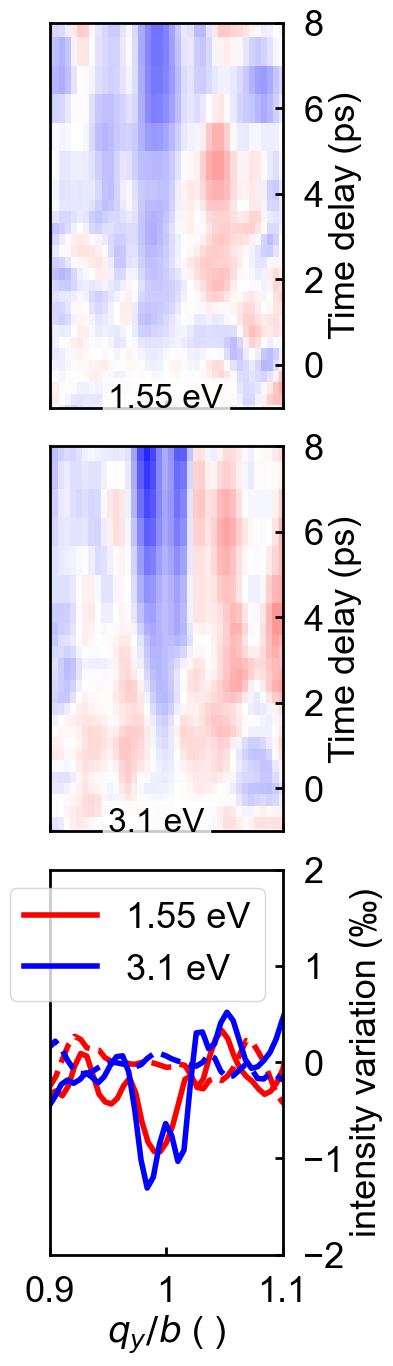

In [ ]:
plt.figure(figsize = (3, 16))
c=['r', 'b']
w = 0.5
sens=0.002
lim=15
dk=0.2*b
print(t3, t4)
for k, scan_name in enumerate(scans):
    beforet0 =  data[scan_name]['delay']<-0.5
    aftert0 = ( data[scan_name]['delay']>t3 ) & ( data[scan_name]['delay']<t4)
    kx_cut = (data[scan_name]['kx']>-w) & (data[scan_name]['kx']<w)
    ## ON OFF
    GM_dynamics = (np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2))/(np.mean(data[scan_name]['imgOFF'][:,:, kx_cut], axis=2))
    GM_late = (np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[aftert0,:], axis=0))/(np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[aftert0,:], axis=0))
    GM_bt0 = (np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[beforet0,:], axis=0))/(np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[beforet0,:], axis=0))

    ### ON ON before t0
    # GM_dynamics = (np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2))/np.mean((np.mean(data[scan_name]['imgON'][:,:, kx_cut], axis=2))[beforet0,:], axis=0)-1
    # GM_late = (np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[aftert0,:], axis=0))/np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)
    # GM_bt0 = 1
    # ax2.set_ylim([-1000, 1000])
    ax = plt.subplot(3,1, k+1)
    ax.pcolor(data[scan_name]['ky'], data[scan_name]['delay'], (GM_dynamics- np.mean(GM_dynamics[beforet0], axis=0)), vmin=-sens, vmax = sens, cmap = 'bwr')
    ax.set_xlim([L*cal-dk, L*cal+dk])
    ax.set_ylim([-1, 8])
    # print(data[scan_name]['ky'][l1])
    ax.set_ylabel('Time delay (ps)')
    ax.tick_params(axis='both', direction='in', pad = 15)

    t = plt.text(L*cal-dk/2, -1, scan_name, c='k', fontsize = 24)#, fontweight = 'bold')
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

    ax.set_xticks([L*cal-dk, L*cal ,L*cal+dk])
    ax.set_xticklabels([])
    ax.tick_params(axis='both', direction='in', pad = 15)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')



    ax2 = plt.subplot(3,1,3)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right')
    ax2.plot(data[scan_name]['ky'],1e3*( GM_late-GM_bt0), c=c[k], linewidth = 4, label=scan_name)
    ax2.plot(data[scan_name]['ky'],1e3*(GM_dynamics[1]- GM_bt0), '--', c=c[k], linewidth = 4)
    # ax2.set_xlim([0, lim])
    ax2.set_xlim([L*cal-dk, L*cal+dk])
    ax2.set_ylim([-2,2])
    ax2.set_xticks([L*cal-dk, L*cal ,L*cal+dk])
    ax2.set_xticklabels([0.9,1,1.1])
    ax2.tick_params(axis='both', direction='in', pad = 15)


ax2.set_ylabel(r'intensity variation (‰)')
ax2.set_xlabel(r'$q_y/b$ ( )')
ax2.legend()

plt.subplots_adjust(hspace = 0.1)
plt.savefig(r'.\diff_UED_binning.pdf', format='pdf', bbox_inches='tight')



In [ ]:
count_g_center = []
kx_cut = (data[scans[0]]['kx']>-w) & (data[scans[0]]['kx']<w)
ky_cut = np.abs(data[scans[0]]['ky']-L*cal)<9e-2
print(data[scans[0]]['ky'][ky_cut])
for scan in scans:
    kx_cut = (data[scan]['kx']>-w) & (data[scan]['kx']<w)
    ky_cut = np.abs(data[scan]['ky']-L*cal)<5e-2
    count_g_center.append((np.mean(np.mean(data[scan]['imgON'][:, :, kx_cut], axis=2)[:,ky_cut], axis=1)) \
        / (np.mean(np.mean(data[scan]['imgOFF'][:, :, kx_cut], axis=2)[:,ky_cut], axis=1)))
    

fig, axis = plt.subplots(1, 1, figsize=(10, 10))
for i, c in enumerate(count_g_center):
    axis.plot(data[scans[i]]['delay'], c/c[0])
axis.set_xlim(-2, 10)

In [ ]:
plt.figure(figsize = (10, 11))
c=['r', 'b']
# w = 1
sens=0.004
t3=4
for k, scan_name in enumerate(scans):
    beforet0 =  data[scan_name]['delay']<-0.5
    kx_cut = (data[scan_name]['kx']>-w) & (data[scan_name]['kx']<w)
    # GM_dynamics = (np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2))/(np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[:,:], axis=1))[:, np.newaxis] \
    #     - (np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2))/(np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[:,:], axis=1))[:, np.newaxis]\
    #     - (np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)))\
    # - np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[beforet0,:], axis=0))) )
    GM_dynamics = (np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2))/(np.mean(data[scan_name]['imgOFF'][:,:, kx_cut], axis=2))

    aftert0 = ( data[scan_name]['delay']>t3 ) & ( data[scan_name]['delay']<t4)
    # GM_late = np.mean(GM_dynamics[aftert0, :], axis=0)
    # GM_bt0 = np.mean(GM_dynamics[beforet0, :], axis=0)
    # GM_late = np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[aftert0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[aftert0,:], axis=0)))\
    # - np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[aftert0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[aftert0,:], axis=0)))
    # GM_bt0 = np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)))\
    # - np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[beforet0,:], axis=0))) 
    ax = plt.subplot(2,1, k+1)
    ax.pcolor(data[scan_name]['ky'], data[scan_name]['delay'], (GM_dynamics- np.mean(GM_dynamics[beforet0], axis=0)), vmin=-sens, vmax = sens, cmap = 'bwr')
    ax.set_xlim([0, 7.5])
    ax.set_ylim([-1, 8])
    ax.set_ylabel('Time delay (ps)')
    ax.tick_params(axis='both', direction='in', pad = 15)
    # ax.set_xticks([0, 5])
    # plt.axhline(0, c= 'k', ls='--', lw =0.5 )

    # plt.axvline(L*cal, c= 'k', ls='--', lw =0.5 )
    # plt.axvline(2*L*cal, c= 'k', ls='--', lw =0.5 )
    t = plt.text(6, 7, scan_name, c='k', fontsize = 24)#, fontweight = 'bold')
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
    # ax.set_xticklabels([r'$\Gamma_{000}$', r'$\Gamma_{100}$', r'$\Gamma_{200}$'])
    # ax.set_xticklabels([r'$000$', r'$100$', r'$200$'])

    # if k>0:
    #     plt.xlabel(r'$q_y (r.l.u)$')
    # else:
    #     ax.set_xticklabels([])
    ax.set_xticks([0, L*cal, 2*L*cal])
    if k == 0 : 
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels([r'$0$', r'$1$', r'$2$'])
        # ax.set_xlabel(r'$q_y/b$ ( )')
        ax.set_xlabel(r'$(H00)$ (r.l.u.)')


plt.subplots_adjust(hspace = 0.1)
plt.savefig(path+r'\diff_UED_binning.pdf', format='pdf', bbox_inches='tight')

# plt.savefig(path+r'\diff_UED.png', bbox_inches='tight', dpi =600)

In [ ]:
plt.figure(figsize = (10, 11))
c=['r', 'b']
# w = 1
sens=0.004
t3=4
for k, scan_name in enumerate(scans):
    beforet0 =  data[scan_name]['delay']<-0.5
    kx_cut = (data[scan_name]['kx']>-w) & (data[scan_name]['kx']<w)
    # GM_dynamics = (np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2))/(np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[:,:], axis=1))[:, np.newaxis] \
    #     - (np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2))/(np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[:,:], axis=1))[:, np.newaxis]\
    #     - (np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)))\
    # - np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[beforet0,:], axis=0))) )
    GM_dynamics = (np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2))/(np.mean(data[scan_name]['imgOFF'][:,:, kx_cut], axis=2))

    aftert0 = ( data[scan_name]['delay']>t3 ) & ( data[scan_name]['delay']<t4)
    # GM_late = np.mean(GM_dynamics[aftert0, :], axis=0)
    # GM_bt0 = np.mean(GM_dynamics[beforet0, :], axis=0)
    GM_late = np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[aftert0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[aftert0,:], axis=0)))\
    - np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[aftert0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[aftert0,:], axis=0)))
    GM_bt0 = np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgON'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)))\
    - np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[beforet0,:], axis=0)/np.mean((np.mean(np.mean(data[scan_name]['imgOFF'][:, :, kx_cut], axis=2)[beforet0,:], axis=0))) 
    ax = plt.subplot(3,1, k+1)
    ax.pcolor(data[scan_name]['ky'], data[scan_name]['delay'], (GM_dynamics- np.mean(GM_dynamics[beforet0], axis=0)), vmin=-sens, vmax = sens, cmap = 'bwr')
    ax.set_xlim([0, 7.5])
    ax.set_ylim([-1, 8])
    ax.set_ylabel('Time delay (ps)')
    ax.tick_params(axis='both', direction='in', pad = 15)
    # ax.set_xticks([0, 5])
    # plt.axhline(0, c= 'k', ls='--', lw =0.5 )

    # plt.axvline(L*cal, c= 'k', ls='--', lw =0.5 )
    # plt.axvline(2*L*cal, c= 'k', ls='--', lw =0.5 )
    t = plt.text(6, 7, scan_name, c='k', fontsize = 24)#, fontweight = 'bold')
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
    # ax.set_xticklabels([r'$\Gamma_{000}$', r'$\Gamma_{100}$', r'$\Gamma_{200}$'])
    # ax.set_xticklabels([r'$000$', r'$100$', r'$200$'])

    # if k>0:
    #     plt.xlabel(r'$q_y (r.l.u)$')
    # else:
    #     ax.set_xticklabels([])
    ax.set_xticks([0, L*cal, 2*L*cal])
    ax.set_xticklabels([])
    ax2 = plt.subplot(3,1,3)
    ax2.plot(data[scan_name]['ky'],1e3*( GM_late-GM_bt0), c=c[k], linewidth = 2, label=scan_name)
    ax2.set_xlim([0, 7.5])
    ax2.set_xticks([0, L*cal, 2*L*cal])
    ax2.set_xticklabels([r'$0$', r'$1$', r'$2$'])
    ax2.set_ylim(-1.1, 1.5)
    ax.tick_params(axis='both', direction='in', pad = 15)
    # if k == 0: 
    #     axtwin = ax.twinx()
    #     axtwin.set_xticklabels([r'$000$', r'$100$', r'$200$'])
# ax2.set_xticklabels([0, '%.2f'%(L*cal), '%.2f'%(2*L*cal)])
ax2.set_ylabel(r'intensity variation (‰)')
ax2.set_xlabel(r'$(0K0)$ (r.l.u)')
ax2.legend()

plt.subplots_adjust(hspace = 0.1)
plt.savefig(path+r'\diff_UED_binning.pdf', format='pdf', bbox_inches='tight')

# plt.savefig(path+r'\diff_UED.png', bbox_inches='tight', dpi =600)